In [1]:
%cd '../'

/mnt/md2/geoframework/models/rnd/happy_whale/model


In [24]:
import os
import random

from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch.nn import functional as F
import torchmetrics.functional as M

import albumentations as A
from albumentations.pytorch import ToTensorV2

from trainer import TorchLightNet
from generator import MyDataset
from make_data_frame import make_data_frame
from settings import exp, csv_folder, check_pointer_path, sub_exp, AVAIL_GPUS

from model import SNUNet

In [3]:
device = torch.device('cuda:1')

chk_path = os.path.join(
    check_pointer_path,
    'epoch=51-val_loss=0.6552-val_acc=0.6245.ckpt'
)
model = TorchLightNet.load_from_checkpoint(checkpoint_path=chk_path)
model.to(device)
model.eval()

dataset, df = make_data_frame(csv_folder,
                              'train_df.csv',
                              'validate_df.csv',
                              'test_df.csv')
train = df.get('train')
validate = df.get('validate')
test = df.get('test')

batch_size = 32
train_full_batch = (train.shape[0] // batch_size) * batch_size

train_transform = A.Compose(
    [
        A.Resize(width=128, height=128),
        A.CenterCrop(width=64, height=64),
        A.HorizontalFlip(p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.25),
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.Normalize(mean=0, std=1),
        ToTensorV2(),
    ],
    additional_targets={'image_b': 'image'}
)
train_dataset = MyDataset(train[:train_full_batch], transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=6)

val_transform = A.Compose(
    [
        A.Resize(width=128, height=128),
        A.Normalize(mean=0, std=1),
        ToTensorV2(),
    ],
    additional_targets={'image_b': 'image'}
)
val_dataset = MyDataset(validate, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, shuffle=False, num_workers=6)

test_dataset = MyDataset(test, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False, num_workers=6)

In [6]:
labels_list = []
preds_list = []
logits_list = []
bi_preds_list = []

ims_a = []
ims_b = []

for idx, inputs, labels in tqdm(test_loader):
    im_a = inputs['first']
    im_b = inputs['second']
    
    im_a = im_a.to(device, dtype=torch.float)
    im_b = im_b.to(device, dtype=torch.float)
    labels = labels.to(device, dtype=torch.float)

    with torch.set_grad_enabled(False):
        preds = model({'first': im_a, 'second': im_b})
    
    logits = torch.sigmoid(preds)
    
    threshold = torch.tensor([0.5])
    threshold = threshold.to(device, dtype=torch.float)
    bi_preds = (logits > threshold).float() * 1
    acc = M.accuracy(bi_preds.int(), labels.int())
    
    labels_list.append(labels.data.cpu().numpy().flatten())
    preds_list.append(preds.data.cpu().numpy().flatten())
    logits_list.append(logits.data.cpu().numpy().flatten())
    bi_preds_list.append(bi_preds.data.cpu().numpy().flatten())

labels_array = np.concatenate(labels_list)
preds_array = np.concatenate(preds_list)
logits_array = np.concatenate(logits_list)
bi_preds_array = np.concatenate(bi_preds_list)

100%|██████████| 320/320 [06:52<00:00,  1.29s/it]


In [16]:
df_res = pd.DataFrame(data={
    'preds': preds_array,
    'logits': logits_array,
    'bi_preds': bi_preds_array
})
df_res = pd.concat([test, df_res], axis=1)

In [29]:
df_res.head()

,image_a,species,individual_id,image_b,label,labels,preds,logits,bi_preds
0,/media/storage3/data3T/happy_whale/train_image...,beluga,ea885e861588,/media/storage3/data3T/happy_whale/train_image...,1,1.0,-2.848512,0.054758,0.0
1,/media/storage3/data3T/happy_whale/train_image...,beluga,ea885e861588,/media/storage3/data3T/happy_whale/train_image...,1,1.0,-3.663785,0.024995,0.0
2,/media/storage3/data3T/happy_whale/train_image...,beluga,ea885e861588,/media/storage3/data3T/happy_whale/train_image...,1,1.0,-0.718221,0.327785,0.0
3,/media/storage3/data3T/happy_whale/train_image...,beluga,ea885e861588,/media/storage3/data3T/happy_whale/train_image...,1,1.0,-1.260337,0.220916,0.0
4,/media/storage3/data3T/happy_whale/train_image...,beluga,ea885e861588,/media/storage3/data3T/happy_whale/train_image...,1,1.0,-0.282383,0.429870,0.0


In [38]:
precision, recall, f1, _ = precision_recall_fscore_support(labels_array,
                                                           bi_preds_array,
                                                           average='macro'  # cause we have balanced classes
                                                          )
print(f'precision is {round(precision, 2)}, recall is {round(recall, 2)}, f1 is {round(f1, 2)}')

precision is 0.68, recall is 0.62, f1 is 0.58


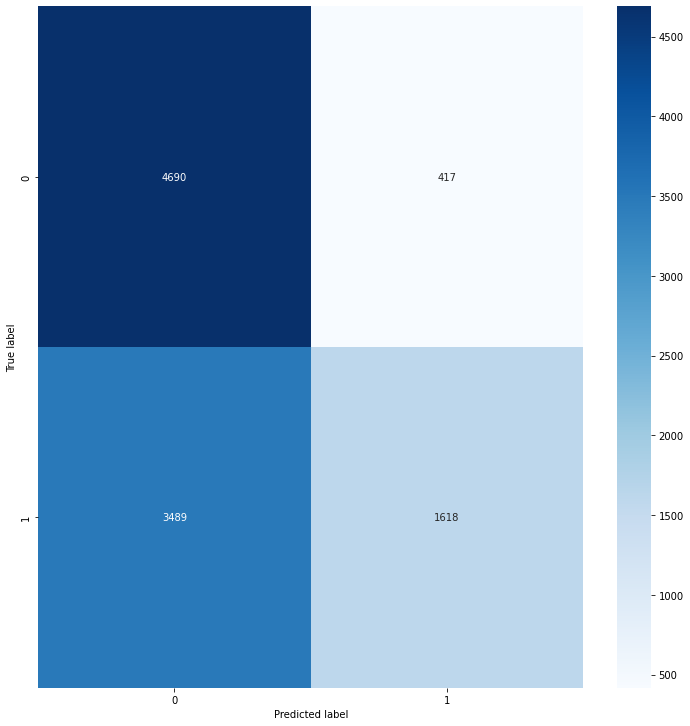

In [26]:
conf_matrix = metrics.confusion_matrix(labels_array, bi_preds_array) 
conf_matrix_df = pd.DataFrame(conf_matrix)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_df,
            annot=True,
            fmt='d',
            cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<AxesSubplot:>

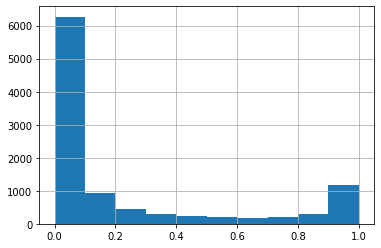

In [39]:
df_res['logits'].hist()

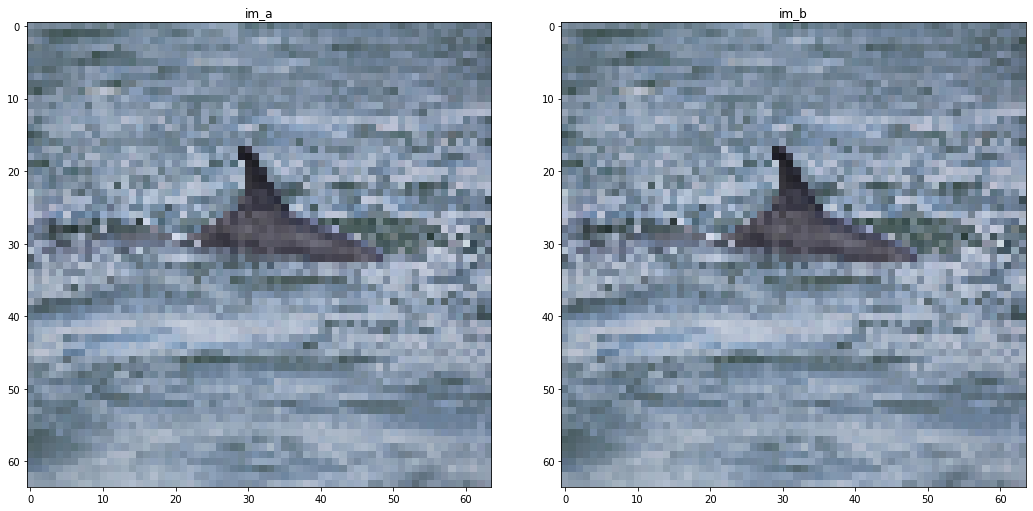

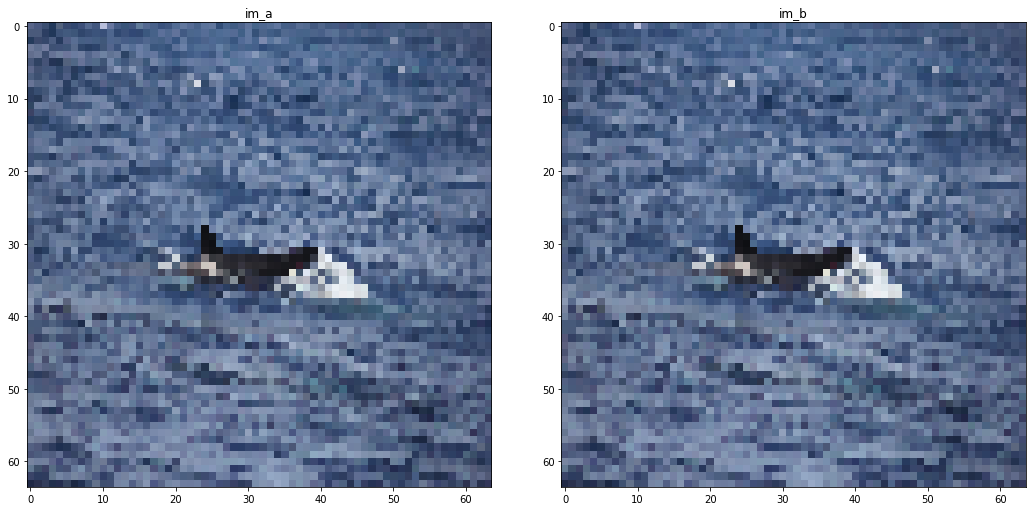

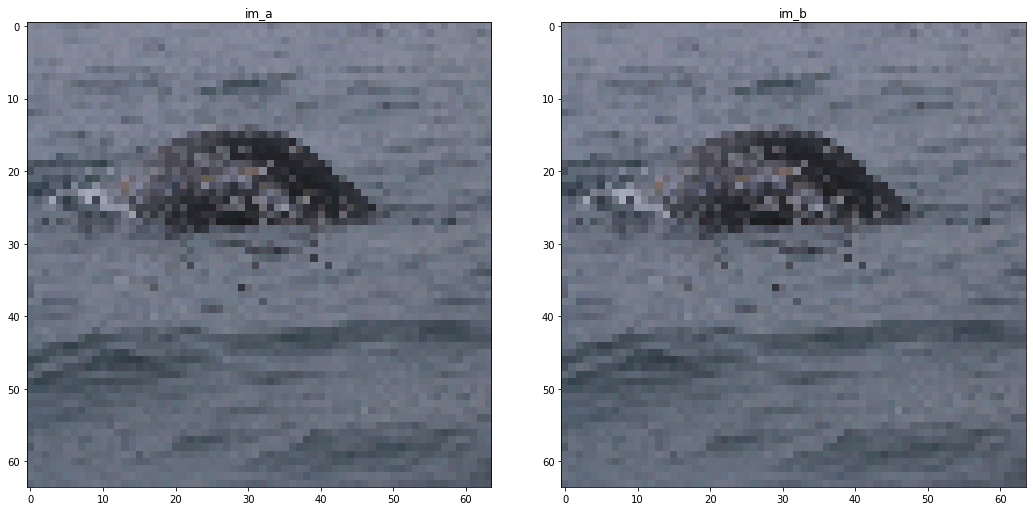

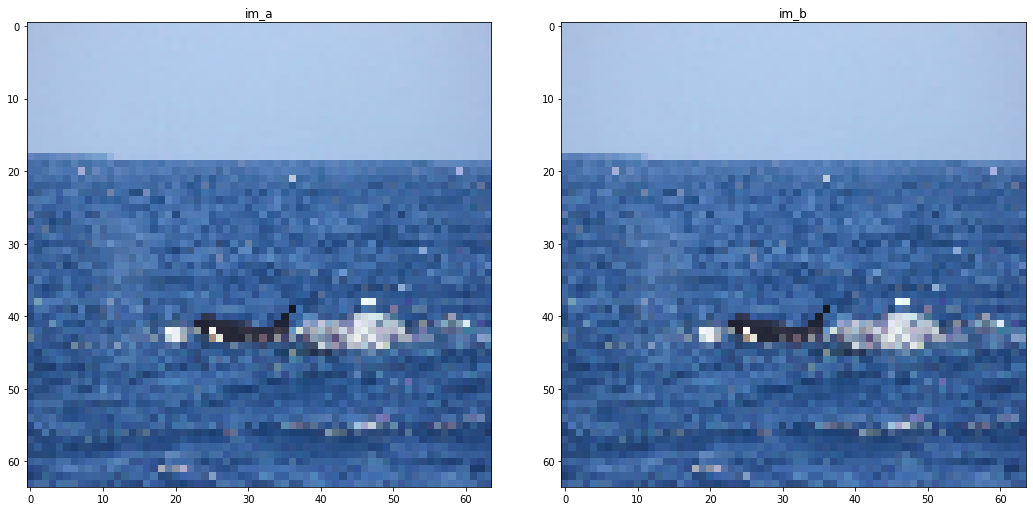

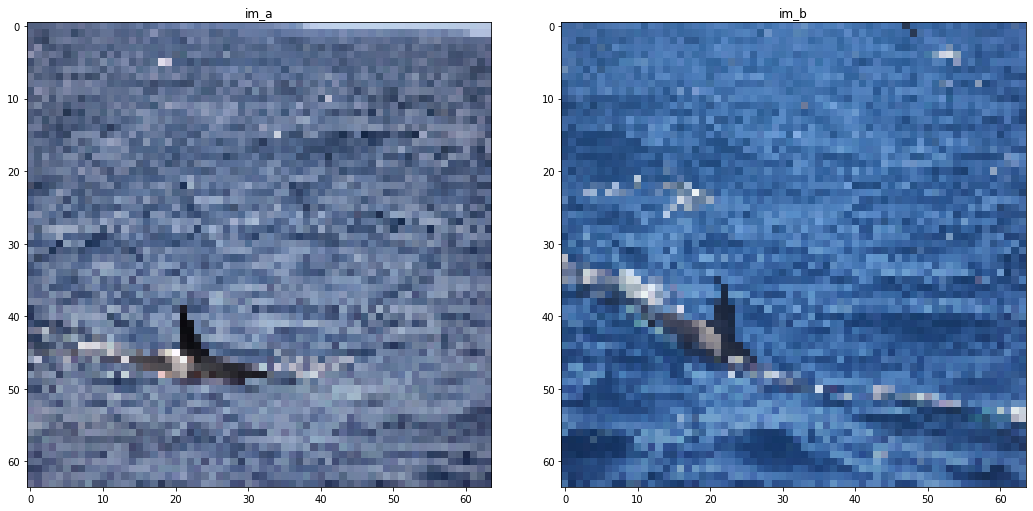

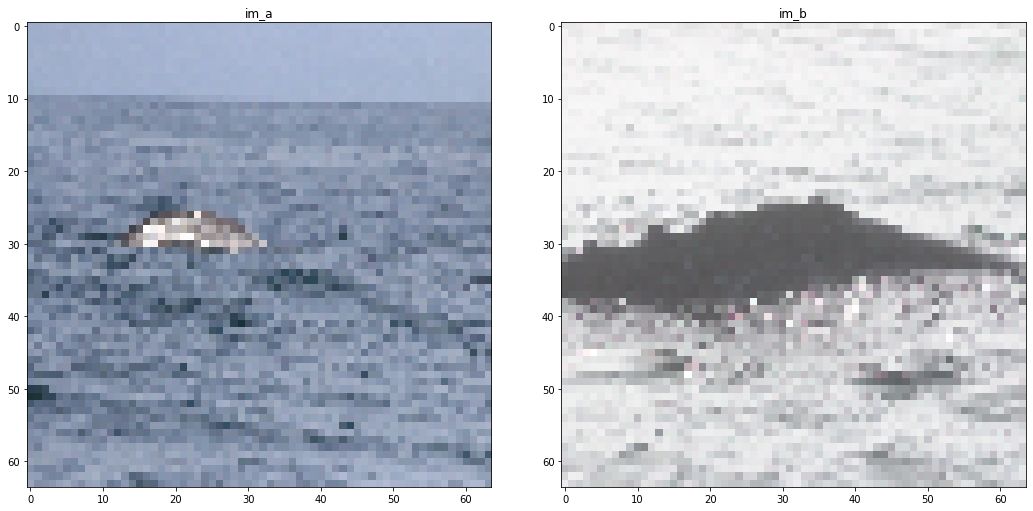

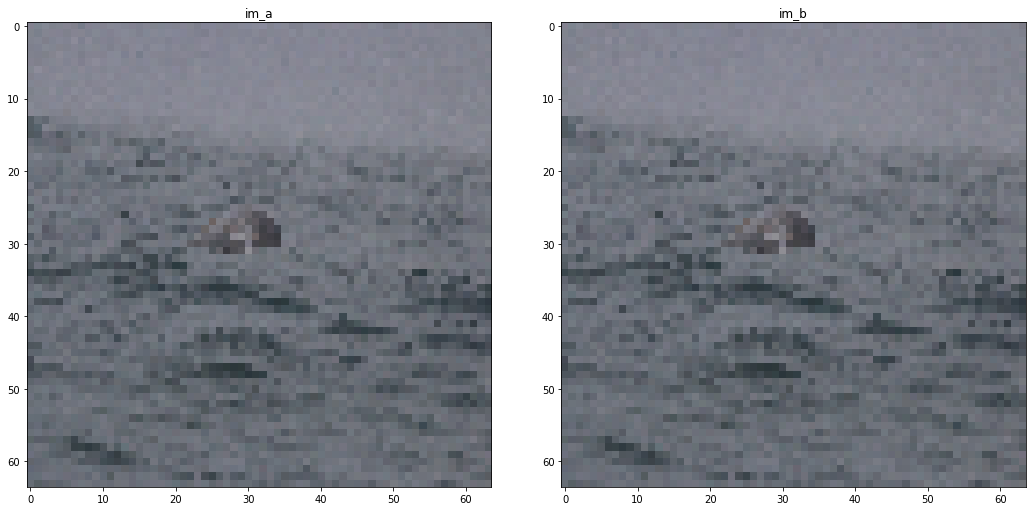

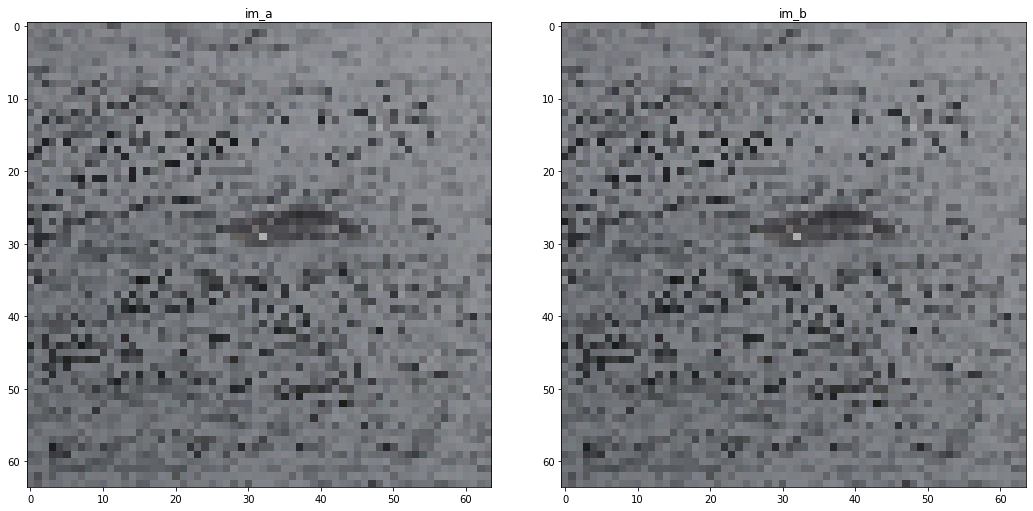

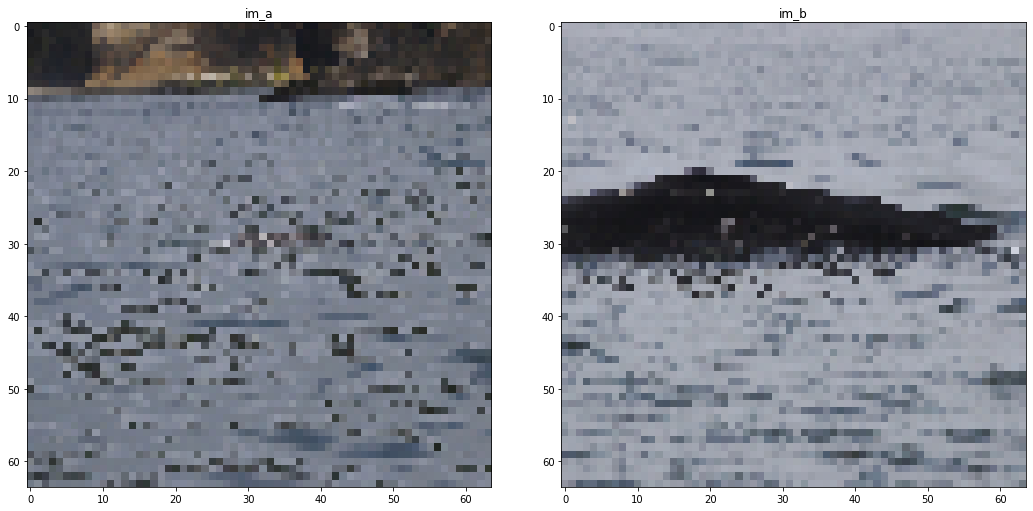

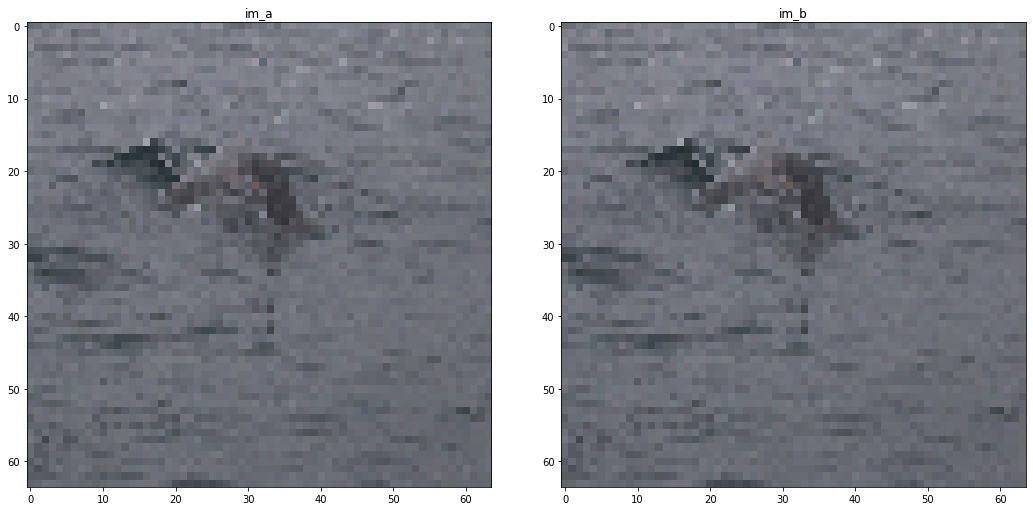

In [25]:
for idx in random.sample(range(0, 63), 10):

    im_a = ims_a[idx]
    im_a = im_a.data.cpu().numpy()
    im_a = np.swapaxes(im_a, 0, 2)
    im_a = np.swapaxes(im_a, 0, 1)
    
    im_b = ims_b[idx]
    im_b = im_b.data.cpu().numpy()
    im_b = np.swapaxes(im_b, 0, 2)
    im_b = np.swapaxes(im_b, 0, 1)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

    ax1.imshow(im_a, interpolation='nearest')
    ax1.title.set_text('im_a')

    ax2.imshow(im_b, interpolation='nearest')
    ax2.title.set_text('im_b')

    fig.tight_layout(rect=[0, 0.50, 1, 0.95])
    plt.show()